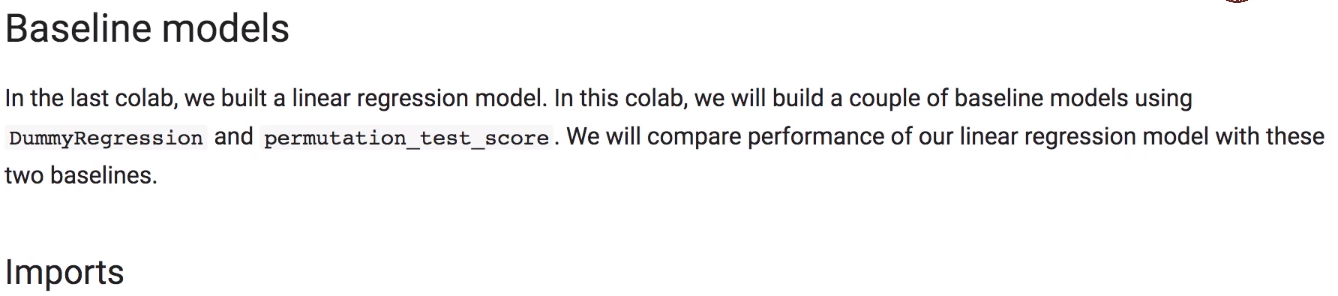

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

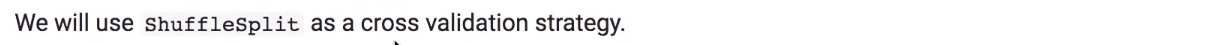

In [4]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

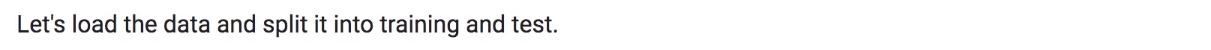

In [5]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)

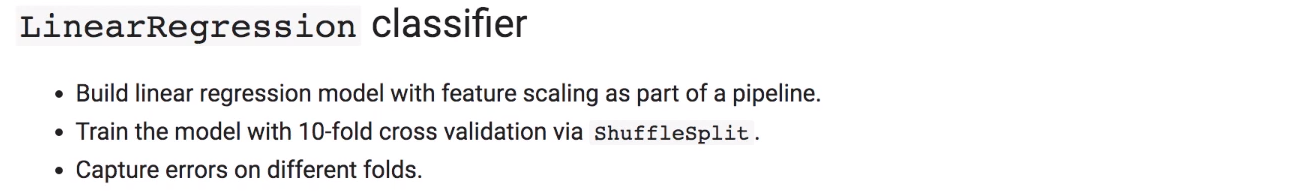

In [6]:
lin_reg_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('lin_reg', LinearRegression())
])

lin_reg_cv_results = cross_validate(lin_reg_pipeline, train_features, train_labels, 
                                    cv=shuffle_split_cv, scoring='neg_mean_absolute_error', n_jobs=2)

lin_reg_errors = pd.Series(-lin_reg_cv_results['test_score'],
                           name='Linear regression error')

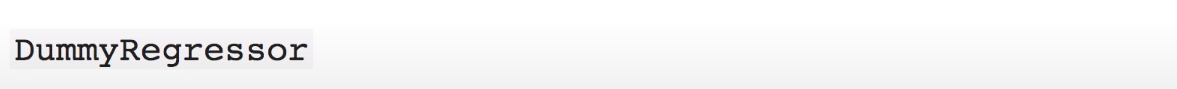

In [9]:
def dummy_regressor_baseline(strategy, constant_val=None, quantile_val=None):
    baseline_model_median = DummyRegressor(strategy=strategy, constant=constant_val, quantile=quantile_val)
    baseline_median_cv_results = cross_validate(
        baseline_model_median, train_features, train_labels, cv=shuffle_split_cv,
        scoring='neg_mean_absolute_error', n_jobs=2
    )
    return pd.Series(-baseline_median_cv_results['test_score'], name='Dummy regressor error')

In [10]:
baseline_median_cv_results_errors = dummy_regressor_baseline(strategy='median')
baseline_mean_cv_results_errors = dummy_regressor_baseline(strategy='mean')
baseline_constant_cv_results_errors = dummy_regressor_baseline(strategy='constant', constant_val=2)
baseline_quantile_cv_results_errors = dummy_regressor_baseline(strategy='quantile', quantile_val=0.55)

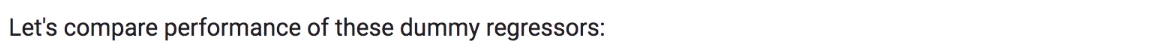

In [11]:
dummy_error_df = pd.concat([
    baseline_median_cv_results_errors,
    baseline_mean_cv_results_errors,
    baseline_constant_cv_results_errors,
    baseline_quantile_cv_results_errors
], axis=1)
dummy_error_df.columns = ['Median CV', 'Mean CV', 'Constant CV', 'Quantile CV']

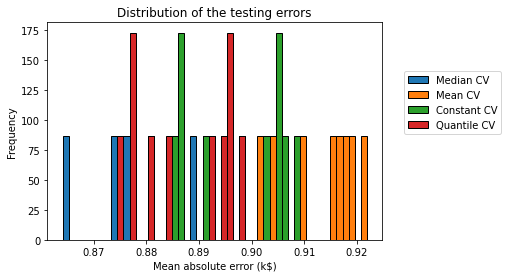

In [12]:
dummy_error_df.plot.hist(bins=50, density=True, edgecolor='black')
plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left')
plt.xlabel('Mean absolute error (k$)')
_ = plt.title('Distribution of the testing errors')

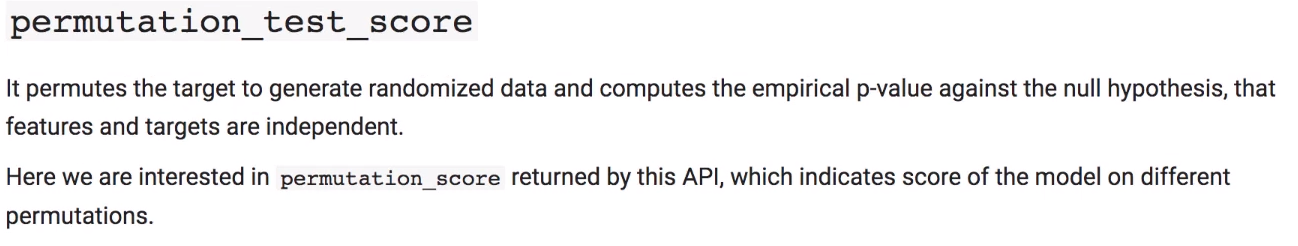

In [13]:
score, permutation_score, pvalue = permutation_test_score(
        lin_reg_pipeline, train_features, train_labels, 
        cv=shuffle_split_cv, scoring='neg_mean_absolute_error',
        n_jobs=2, n_permutations=30
    )
permutation_errors = pd.Series(-permutation_score, name='Permuted error')

In [14]:
print(permutation_score)

[-0.91446539 -0.91608713 -0.91501122 -0.91112203 -0.91326112 -0.91428719
 -0.91694297 -0.90660687 -0.90873595 -0.91546138 -0.9084695  -0.91174023
 -0.91857102 -0.91467076 -0.90396709 -0.91239289 -0.91095499 -0.91729623
 -0.90529415 -0.91436609 -0.91993036 -0.91661883 -0.91104746 -0.91563156
 -0.91014294 -0.91526135 -0.90680247 -0.90796435 -0.91032999 -0.91545574]


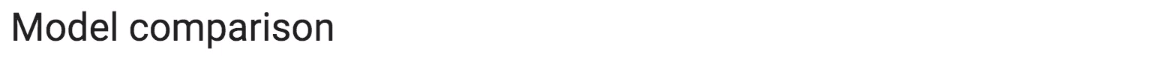

In [15]:
error_df = pd.concat([lin_reg_errors, baseline_median_cv_results_errors, permutation_errors], axis=1)

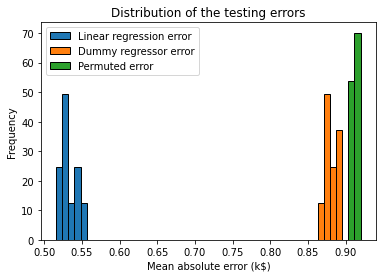

In [16]:
error_df.plot.hist(bins=50, density=True, edgecolor='black')
plt.legend(loc='best')
plt.xlabel('Mean absolute error (k$)')
_ = plt.title('Distribution of the testing errors')

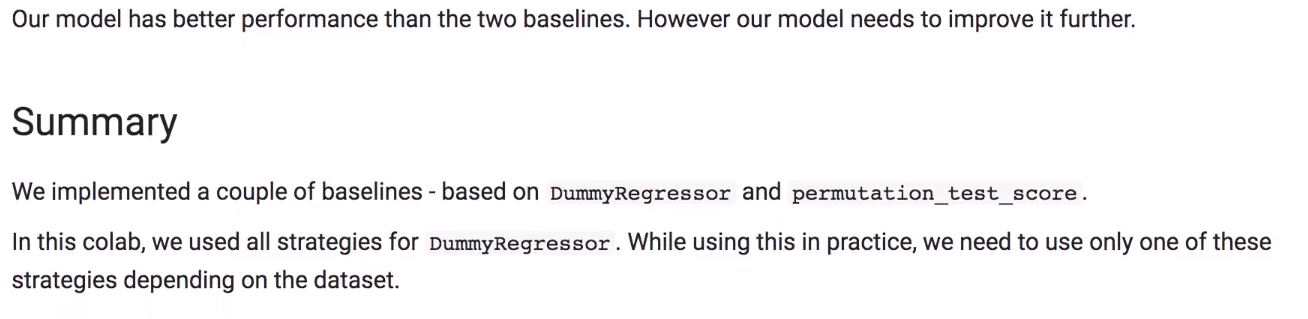